In [ ]:
!pip install arch

In [ ]:
!pip install yfinance --upgrade --no-cache-dir

Fetched 5283 rows for ^GSPC
Fetched 5283 rows for ^VIX
Combined data shape after initial NaN handling: (5283, 2)
Data shape after calculating returns/vol and dropping NaNs: (5277, 6) (dropped 6 rows)
Data preprocessed. Sample:
                    SPX        VIX  SPX_LogRet  VIX_Level  Realized_Vol  \
Date                                                                      
2000-01-10  1457.599976  21.709999    0.011128  21.709999      0.386499   
2000-01-11  1438.560059  22.500000   -0.013149  22.500000      0.233255   
2000-01-12  1432.250000  22.840000   -0.004396  22.840000      0.243477   
2000-01-13  1449.680054  21.709999    0.012096  21.709999      0.246793   
2000-01-14  1465.150024  19.660000    0.010615  19.660000      0.181333   

            Realized_Vol_Target  
Date                             
2000-01-10             0.233255  
2000-01-11             0.243477  
2000-01-12             0.246793  
2000-01-13             0.181333  
2000-01-14             0.177061  

Data Spl

Epoch [1/30], Average Loss: 0.013890


Epoch [2/30], Average Loss: 0.005503


Epoch [3/30], Average Loss: 0.005038


Epoch [4/30], Average Loss: 0.004771


Epoch [5/30], Average Loss: 0.004716


Epoch [6/30], Average Loss: 0.004538


Epoch [7/30], Average Loss: 0.004487


Epoch [8/30], Average Loss: 0.004378


Epoch [9/30], Average Loss: 0.004694


Epoch [10/30], Average Loss: 0.004431


Epoch [11/30], Average Loss: 0.004181


Epoch [12/30], Average Loss: 0.004238


Epoch [13/30], Average Loss: 0.004060


Epoch [14/30], Average Loss: 0.004015


Epoch [15/30], Average Loss: 0.004029


Epoch [16/30], Average Loss: 0.004084


Epoch [17/30], Average Loss: 0.003970


Epoch [18/30], Average Loss: 0.003967


Epoch [19/30], Average Loss: 0.003920


Epoch [20/30], Average Loss: 0.003882


Epoch [21/30], Average Loss: 0.003877


Epoch [22/30], Average Loss: 0.003847


Epoch [23/30], Average Loss: 0.003691


Epoch [24/30], Average Loss: 0.004078


Epoch [25/30], Average Loss: 0.003834


Epoch [26/30], Average Loss: 0.003761


Epoch [27/30], Average Loss: 0.003673


Epoch [28/30], Average Loss: 0.003621


Epoch [29/30], Average Loss: 0.003542


<ipython-input-30-7b0dca52f7b7>:242: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_h_garch = res_garch_initial.conditional_volatility[-1]**2 / (100**2) # Variance = vol^2, unscale


Epoch [30/30], Average Loss: 0.003504
LSTM (Volatility) Training finished.

Fitting initial GARCH model on log returns...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             SPX_LogRet   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5988.12
Distribution:                  Normal   AIC:                           11982.2
Method:            Maximum Likelihood   BIC:                           12001.3
                                        No. Observations:                 4221
Date:                Mon, May 05 2025   Df Residuals:                     4221
Time:                        10:26:03   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-------------

Rolling Forecast: 100%|██████████| 1055/1055 [00:01<00:00, 685.37it/s]


Rolling forecast finished.

--- Evaluating Model Performance ---
Evaluation Metrics (Test Set):

--- GARCH ---
MAE:  0.050324
MSE:  0.005366
RMSE: 0.073255

--- LSTM ---
MAE:  0.039733
MSE:  0.004155
RMSE: 0.064460

--- Combined_LSTM_GARCH ---
MAE:  0.041363
MSE:  0.003729
RMSE: 0.061067

--- Objective Check ---
Baseline GARCH RMSE:         0.073255
Combined LSTM-GARCH RMSE:  0.061067
RMSE Reduction vs GARCH: 16.64%
Objective MET: Combined model achieved >= 15% RMSE reduction vs GARCH.


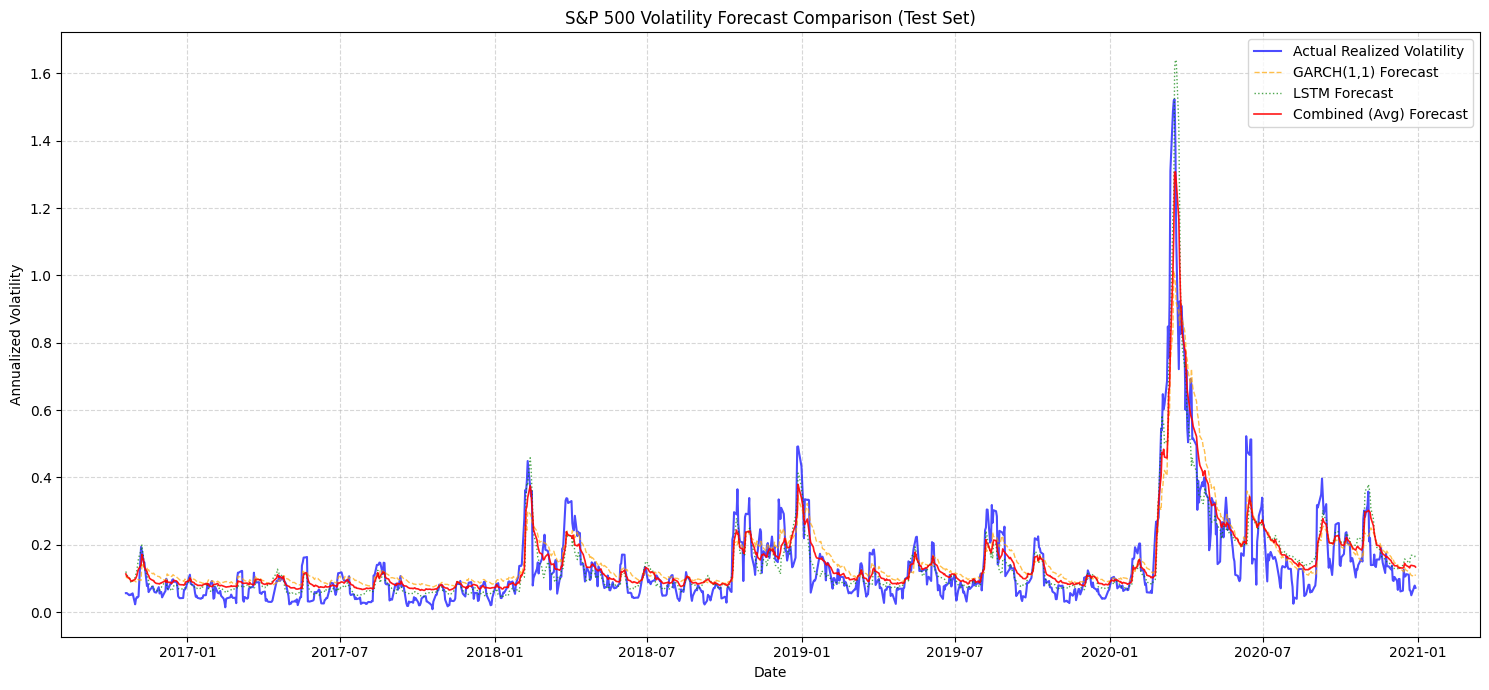

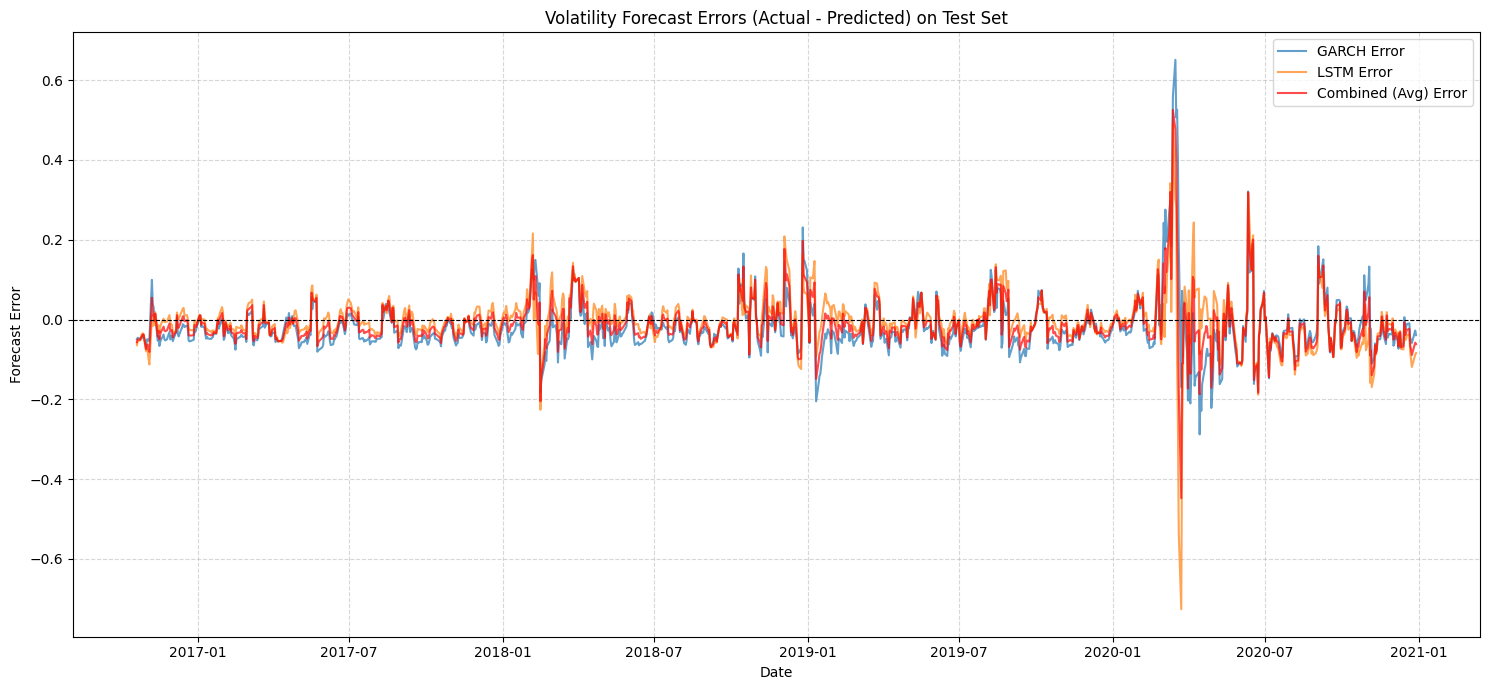

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm # For progress bars
import math # For sqrt

# --- Parameters ---
# Data Parameters
TICKER_SPX = '^GSPC'
TICKER_VIX = '^VIX'
START_DATE = '2000-01-01'
END_DATE = '2020-12-31'

# Preprocessing Parameters
REALIZED_VOL_WINDOW = 5
ANNUALIZATION_FACTOR = np.sqrt(252)

# Model Parameters
LSTM_INPUT_SEQ_LEN = 120
LSTM_HIDDEN_SIZE = 24
LSTM_NUM_LAYERS = 1
LSTM_DROPOUT = 0.3
GARCH_P = 1
GARCH_Q = 1

# Training & Rolling Window Parameters
TRAIN_TEST_SPLIT_RATIO = 0.8
LSTM_EPOCHS = 30
LSTM_BATCH_SIZE = 32
LSTM_LEARNING_RATE = 0.001
PERIODIC_RETRAIN = False # Keep False unless implementing re-training logic
RETRAIN_INTERVAL = 252
history = {'loss': []}

# --- Data Fetching and Preprocessing ---
def fetch_data(ticker, start, end):
    """Fetches historical adjusted closing prices from Yahoo Finance."""
    try:
        data = yf.download(ticker, start=start, end=end, progress=False)
        if data is None or data.empty:
            raise ValueError(f"No data fetched for {ticker}")
        print(f"Fetched {len(data)} rows for {ticker}")
        return data['Close']
    except Exception as e:
        print(f"Error fetching data for {ticker}: {type(e).__name__}, {e}")
        return None

spx_price = fetch_data(TICKER_SPX, START_DATE, END_DATE)
vix_price = fetch_data(TICKER_VIX, START_DATE, END_DATE)

if spx_price is None or vix_price is None:
    raise SystemExit("Failed to fetch necessary data. Exiting.")

df = pd.concat([spx_price, vix_price], axis=1)
df.columns = ['SPX', 'VIX']
df.ffill(inplace=True)
df.dropna(inplace=True)
print(f"Combined data shape after initial NaN handling: {df.shape}")

# Calculate Features and Targets
df['SPX_LogRet'] = np.log(df['SPX'] / df['SPX'].shift(1))
df['VIX_Level'] = df['VIX'] # Feature for LSTM

# Calculate Realized Volatility (Target for LSTM and Evaluation)
df['Realized_Vol'] = df['SPX_LogRet'].rolling(window=REALIZED_VOL_WINDOW).std() * ANNUALIZATION_FACTOR
df['Realized_Vol_Target'] = df['Realized_Vol'].shift(-1) # Predict vol for t+1 using info up to t

initial_rows = len(df)
df.dropna(inplace=True)
print(f"Data shape after calculating returns/vol and dropping NaNs: {df.shape} (dropped {initial_rows - len(df)} rows)")

print("Data preprocessed. Sample:")
print(df.head())

# --- Train/Test Split ---
n_obs = len(df)
n_train = int(n_obs * TRAIN_TEST_SPLIT_RATIO)
train_df = df.iloc[:n_train].copy()
test_df = df.iloc[n_train:].copy()
test_indices = df.index[n_train:]

print(f"\nData Split:")
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# --- Feature Scaling ---
# Scale features used by LSTM: Log Returns and VIX Level
scaler_logret = MinMaxScaler(feature_range=(-1, 1))
scaler_vix = MinMaxScaler(feature_range=(-1, 1))

# Fit scalers ONLY on training data
train_df['SPX_LogRet_Scaled'] = scaler_logret.fit_transform(train_df[['SPX_LogRet']])
train_df['VIX_Level_Scaled'] = scaler_vix.fit_transform(train_df[['VIX_Level']])

# Transform test data using the FITTED scalers
test_df['SPX_LogRet_Scaled'] = scaler_logret.transform(test_df[['SPX_LogRet']])
test_df['VIX_Level_Scaled'] = scaler_vix.transform(test_df[['VIX_Level']])

scaled_df = pd.concat([train_df, test_df])

# --- Model Definitions ---
# LSTM Model Definition (Predicts Volatility)
class LSTMVolModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMVolModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :]) # Use output of last time step
        return out

# --- Data Preparation Functions ---
def create_lstm_sequences(data_logret, data_vix, target_data, seq_len):
    """Prepares sequences for LSTM training/prediction."""
    xs, ys = [], []
    data_logret_np = np.array(data_logret)
    data_vix_np = np.array(data_vix)
    target_data_np = np.array(target_data)

    for i in range(len(data_logret_np) - seq_len):
        x_logret = data_logret_np[i:(i + seq_len)]
        x_vix = data_vix_np[i:(i + seq_len)]
        x = np.stack((x_logret, x_vix), axis=1) # Features: LogRet, VIX
        y = target_data_np[i + seq_len] # Target: Value at t+1

        if not np.isnan(y): # Check target validity
            xs.append(x)
            ys.append(y)

    return np.array(xs), np.array(ys)

# --- Training Function ---
def train_lstm(model, dataloader, epochs, learning_rate, device, model_name="LSTM"):
    """ Trains the PyTorch LSTM model. """
    criterion = nn.MSELoss() # Use MSE for volatility prediction
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    model.train()

    print(f"\nTraining {model_name} on {device}...")
    for epoch in range(epochs):
        epoch_loss = 0.0
        pbar_batch = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for inputs, targets in pbar_batch:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze()) # Ensure shapes match

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar_batch.set_postfix({'loss': loss.item()})

        avg_epoch_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_epoch_loss:.6f}')
        history['loss'].append(avg_epoch_loss)

    print(f"{model_name} Training finished.")
    model.eval()
    return model

# --- Initial Model Training ---
print("\n--- Initial Model Training ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Train LSTM (Predicts Volatility Directly)
print("Preparing data for LSTM (Volatility Prediction)...")
# Target is the Realized Volatility (not scaled by default, predict actual value)
X_lstm_train_np, y_lstm_train_np = create_lstm_sequences(
    train_df['SPX_LogRet_Scaled'],      # Input feature 1 (scaled)
    train_df['VIX_Level_Scaled'],       # Input feature 2 (scaled)
    train_df['Realized_Vol_Target'], # Target is the actual realized volatility
    LSTM_INPUT_SEQ_LEN
)

# Convert to PyTorch tensors
X_lstm_train = torch.tensor(X_lstm_train_np, dtype=torch.float32)
y_lstm_train = torch.tensor(y_lstm_train_np, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
lstm_dataset = TensorDataset(X_lstm_train, y_lstm_train)
lstm_dataloader = DataLoader(lstm_dataset, batch_size=LSTM_BATCH_SIZE, shuffle=True)

# Initialize and train the LSTM model
lstm_model = LSTMVolModel(input_size=2, # Two features: LogRet, VIX
                          hidden_size=LSTM_HIDDEN_SIZE,
                          num_layers=LSTM_NUM_LAYERS,
                          output_size=1, # Output is 1 (predicted volatility)
                          dropout=LSTM_DROPOUT).to(device)

lstm_model = train_lstm(lstm_model, lstm_dataloader, LSTM_EPOCHS, LSTM_LEARNING_RATE, device, "LSTM (Volatility)")


# 2. Estimate Initial GARCH Parameters
print("\nFitting initial GARCH model on log returns...")
try:
    # Use log returns directly from the training period
    train_log_returns = train_df['SPX_LogRet'].dropna()
    # Use arch_model for GARCH(1,1)
    garch_model_spec = arch_model(train_log_returns * 100, vol='Garch', p=GARCH_P, q=GARCH_Q,
                                  mean='Zero', dist='Normal') # Scale by 100 for stability
    res_garch_initial = garch_model_spec.fit(disp='off', show_warning=False)
    print(res_garch_initial.summary())

    # Extract parameters needed for rolling forecast
    omega_garch = res_garch_initial.params['omega']
    alpha_garch = res_garch_initial.params['alpha[1]']
    beta_garch = res_garch_initial.params['beta[1]']

    # Get last variance and residual for rolling forecast start (unscale variance/residual)
    last_h_garch = res_garch_initial.conditional_volatility[-1]**2 / (100**2) # Variance = vol^2, unscale
    last_resid_garch = train_log_returns.iloc[-1] # Use the actual last log return as the last 'residual' for standard GARCH
    print("GARCH parameters estimated.")
except Exception as e:
    print(f"ERROR: Initial GARCH fitting failed: {e}")
    raise SystemExit("GARCH fitting failed.")

# --- Rolling Forecast ---
print(f"\n--- Starting Rolling Forecast from {test_indices[0].date()} ---")

predictions = {
    'Date': [],
    'Actual': [],
    'GARCH': [],          # Renamed from GARCH_Baseline
    'LSTM': [],           # Renamed from LSTM_Baseline
    'Combined_LSTM_GARCH': [] # New combined forecast
}

# Set models to evaluation mode
lstm_model.eval()

# Iterate through the test set for rolling predictions
for i in tqdm(range(len(test_indices) - 1), desc="Rolling Forecast"):
    t_index = n_train + i
    current_date = df.index[t_index]
    next_date = df.index[t_index + 1] # Date for which volatility is being predicted

    # 1. Prepare Input Data for step t
    start_idx = t_index - LSTM_INPUT_SEQ_LEN
    end_idx = t_index # Exclusive
    if start_idx < 0: continue # Skip if not enough history

    # Get scaled features for LSTM input
    input_data_logret_scaled = scaled_df['SPX_LogRet_Scaled'].iloc[start_idx:end_idx].values
    input_data_vix_scaled = scaled_df['VIX_Level_Scaled'].iloc[start_idx:end_idx].values

    # Get actual log return at time t needed for GARCH update
    actual_log_ret_t = df['SPX_LogRet'].iloc[t_index]

    # Create LSTM input tensor (shape: [1, seq_len, num_features])
    x_input_np = np.stack((input_data_logret_scaled, input_data_vix_scaled), axis=1).reshape(1, LSTM_INPUT_SEQ_LEN, 2)
    x_input = torch.tensor(x_input_np, dtype=torch.float32).to(device)

    # 2. Get Prediction from LSTM Model (Predicts Volatility sigma_hat_{t+1})
    with torch.no_grad():
        vol_hat_lstm_tplus1 = lstm_model(x_input).cpu().numpy().flatten()[0]
        # Ensure prediction is non-negative
        vol_hat_lstm_tplus1 = max(vol_hat_lstm_tplus1, 0)

    # 3. Calculate GARCH Volatility for t+1
    # Use actual log return at t as the 'innovation' epsilon_t for standard GARCH
    epsilon_t_garch = actual_log_ret_t

    # Calculate variance for day t: h_t = omega + alpha * epsilon_{t-1}^2 + beta * h_{t-1}
    # Use last_resid_garch (logret_{t-1}) and last_h_garch (h_{t-1})
    h_t_garch = omega_garch / (100**2) + alpha_garch * (last_resid_garch**2) + beta_garch * last_h_garch
    # Note: omega was estimated on scaled returns, so unscale it here. alpha/beta are scale invariant.

    # Forecast variance for day t+1: h_{t+1} = omega + alpha * epsilon_t^2 + beta * h_t
    h_tplus1_garch = omega_garch / (100**2) + alpha_garch * (epsilon_t_garch**2) + beta_garch * h_t_garch

    # Ensure variance is positive and calculate annualized volatility
    h_tplus1_garch = max(h_tplus1_garch, 1e-12) # Prevent sqrt(0) or negative
    vol_hat_garch_tplus1 = np.sqrt(h_tplus1_garch) * ANNUALIZATION_FACTOR

    # Update GARCH state for next iteration (t+1)
    last_h_garch = h_t_garch         # h_t becomes the next h_{t-1}
    last_resid_garch = epsilon_t_garch # epsilon_t becomes the next epsilon_{t-1}

    # 4. Calculate Combined Forecast (Simple Average)
    vol_hat_combined_tplus1 = (vol_hat_lstm_tplus1 + vol_hat_garch_tplus1) / 2.0

    # 5. Store Predictions and Actuals for day t+1
    # Actual realized volatility for day t+1 is stored at index t in 'Realized_Vol_Target'
    actual_vol_tplus1 = df['Realized_Vol_Target'].iloc[t_index]

    if not pd.isna(actual_vol_tplus1):
        predictions['Date'].append(next_date) # Store the date the prediction is FOR
        predictions['Actual'].append(actual_vol_tplus1)
        predictions['GARCH'].append(vol_hat_garch_tplus1)
        predictions['LSTM'].append(vol_hat_lstm_tplus1)
        predictions['Combined_LSTM_GARCH'].append(vol_hat_combined_tplus1)
    # else: # If actual is NaN, skip storing this step's predictions


print("Rolling forecast finished.")

# --- Evaluation ---
print("\n--- Evaluating Model Performance ---")

# Create DataFrame for results
results_df = pd.DataFrame(predictions)
results_df.set_index('Date', inplace=True)

# Drop any rows with NaN predictions or actuals
results_df.dropna(inplace=True)

if results_df.empty:
     print("No valid results found for evaluation. Check data or prediction loop.")
else:
    # Calculate Metrics: MAE, RMSE, MSE
    metrics = {}
    print("Evaluation Metrics (Test Set):")
    # Evaluate GARCH, LSTM, and the new Combined model
    for model_name in ['GARCH', 'LSTM', 'Combined_LSTM_GARCH']:
        pred = results_df[model_name]
        actual = results_df['Actual']
        mae = mean_absolute_error(actual, pred)
        mse = mean_squared_error(actual, pred)
        rmse = np.sqrt(mse)
        metrics[model_name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
        print(f"\n--- {model_name} ---")
        print(f"MAE:  {mae:.6f}")
        print(f"MSE:  {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")

    # Check Objective: Compare Combined model against baseline GARCH
    if 'GARCH' in metrics and 'Combined_LSTM_GARCH' in metrics:
        baseline_rmse = metrics['GARCH']['RMSE']
        combined_rmse = metrics['Combined_LSTM_GARCH']['RMSE']
        if baseline_rmse > 0: # Avoid division by zero
             improvement = ((baseline_rmse - combined_rmse) / baseline_rmse) * 100
             print(f"\n--- Objective Check ---")
             print(f"Baseline GARCH RMSE:         {baseline_rmse:.6f}")
             print(f"Combined LSTM-GARCH RMSE:  {combined_rmse:.6f}")
             print(f"RMSE Reduction vs GARCH: {improvement:.2f}%")
             # Set your target improvement percentage here
             target_improvement = 15
             if improvement >= target_improvement:
                 print(f"Objective MET: Combined model achieved >= {target_improvement}% RMSE reduction vs GARCH.")
             else:
                 print(f"Objective NOT MET: Combined model achieved < {target_improvement}% RMSE reduction vs GARCH.")
        else:
             print("\n--- Objective Check ---")
             print("Baseline GARCH RMSE is zero, cannot calculate percentage improvement.")
    else:
        print("\nCould not perform objective check due to missing model results.")

# --- Plotting ---
if not results_df.empty:
    # Plot actual vs predicted volatility
    plt.figure(figsize=(15, 7))
    plt.plot(results_df.index, results_df['Actual'], label='Actual Realized Volatility', alpha=0.7, linewidth=1.5, color='blue')
    plt.plot(results_df.index, results_df['GARCH'], label='GARCH(1,1) Forecast', alpha=0.7, linewidth=1, linestyle='--', color='orange')
    plt.plot(results_df.index, results_df['LSTM'], label='LSTM Forecast', alpha=0.7, linewidth=1, linestyle=':', color='green')
    plt.plot(results_df.index, results_df['Combined_LSTM_GARCH'], label='Combined (Avg) Forecast', alpha=0.9, color='red', linewidth=1.2) # Highlight combined
    plt.title('S&P 500 Volatility Forecast Comparison (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Plot forecast errors
    plt.figure(figsize=(15, 7))
    plt.plot(results_df.index, results_df['Actual'] - results_df['GARCH'], label='GARCH Error', alpha=0.7)
    plt.plot(results_df.index, results_df['Actual'] - results_df['LSTM'], label='LSTM Error', alpha=0.7)
    plt.plot(results_df.index, results_df['Actual'] - results_df['Combined_LSTM_GARCH'], label='Combined (Avg) Error', alpha=0.7, color='red') # Highlight combined error
    plt.title('Volatility Forecast Errors (Actual - Predicted) on Test Set')
    plt.xlabel('Date')
    plt.ylabel('Forecast Error')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plots as results are empty.")

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(lstm_model.state_dict(), '/content/drive/MyDrive/my_model_03.pt')

In [ ]:
import sys
print(sys.version)
!pip freeze > /content/drive/MyDrive/requirements.txt


3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


In [ ]:
pd.DataFrame(history).to_csv('/content/drive/MyDrive/training_log_03.csv')